# 泰坦尼克号沉船事故——乘客生存率数据分析、可视化及决策树模型

## 本项目的基本框架：
1. 定义问题
2. 收集数据
3. 数据清洗
4. 探索性数据分析
5. 使用决策树算法拟合模型
6. 评价模型的性能

## 1.定义问题
1. 背景知识：1912年4月15号英国皇家邮轮泰坦尼克号与冰山相撞沉没。当时船上有1316名乘客和892名船员共计2208人，事故发生后幸存718人，约2/3的人在海难中丧生。按性别划分，男性1738人，女性470人；其中男性存活374人，女性存活344人。更详尽的人员资料请见下面的数据探索部分。
    
2. 我们感兴趣的问题：
    1. 是否有明显的因素决定乘客是否存活？幸存与否与**性别**有没有关系？和**年龄**的关系呢？**舱位等级**是否有影响？诸如此类的问题。
    2. 能否建立一个模型，能对乘客的存活率作一个相对准确的**预测**？

## 2.收集数据
Kaggle平台已经备有较为完整的乘客信息文档，并且出于机器学习的目的，Kaggle官方已经将数据分割为训练集和测试集两个文档。该数据集共记录1309名乘客的信息，包括姓名，性别，年龄等重要信息。

## 3.数据清洗

数据的来源多种多样，有的是人工收集的数据，有的是传感器发回的数据。因此数据的质量是无法保证的。例如数据中缺失值，或者年龄为200岁，诸如此类的麻烦都是我们在作数据分析与挖掘之前先处理掉的事务。同时，数据清洗有一个前提，那就是了解这些数据，数据类型怎样？是独立变量还是依赖其他变量？......

下面就开始数据清洗阶段的工作：

### 3.1 准备工作

#### 1.导入需要用到的常用库

In [1]:
#-*-utf-8-*-   #支持中文注释

#导入需要用到的库，并且打印各个库的版本号
import sys  #获得调用系统参数的权限 
print("Python version:{}".format(sys.version))

import pandas as pd  #专用于作数据分析的库，其中有像数据框这样的核心工具
print("pandas version:{}".format(pd.__version__))

import matplotlib  #交互式画图工具
print("matplotlib version:{}".format(matplotlib.__version__))

import numpy as np  #进行科学计算的基础库，其最大的特点是元素级运算
print("Numpy version:{}".format(np.__version__))

import scipy as sp  #进行科学计算的集成库
print("scipy version:{}".format(sp.__version__))

import IPython
from IPython import display  #美化Notebook中的打印效果
print("IPython version:{}".format(IPython.__version__))

import sklearn  #各种常见机器学习算法的集成库
print("scikit-learn version:{}".format(sklearn.__version__))

#需要的其他库
import random
import time

#为了顺利运行代码，忽略一些无关紧要的警告信息，例如未来版本的警告信息
import warnings
warnings.filterwarnings("ignore")

Python version:3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
pandas version:0.20.3
matplotlib version:2.1.0
Numpy version:1.13.3
scipy version:0.19.1
IPython version:6.1.0
scikit-learn version:0.19.1


#### 2.从sklearn库中导入需要用到的机器学习算法及辅助工具

In [2]:
#后文需要的机器学习算法：决策树
from sklearn import tree

#导入模型训练过程中非常有帮助的一些工具
from sklearn.preprocessing import LabelEncoder  #对分类型数据编码
from sklearn import feature_selection  #该模块中的类可以用来对样本集进行特征选择和降维，有助于提高估计器的准确度及在高维度数据集上的性能
from sklearn import model_selection  #该模块能实现交叉验证、调整估计器的超参数以及模型评估等功能
from sklearn import metrics  #用于计算混淆矩阵、精确率、召回率等数值

#导入作图类工具
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#定制图形展示参数
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#### 3.导入数据集

In [3]:
#使用pandas读取数据
data_raw = pd.read_csv(r"J:\Projects\Datasets\train.csv")
data_val = pd.read_csv(r"J:\Projects\Datasets\test.csv")

#为了不需要重复读取数据，将已读取的数据拷贝一份，以便下面的操作
data1 = data_raw.copy(deep=True)

#整合所有数据，以便下面的数据清洗
#data_cleaner = [data1,data_val]

#### 4.数据预览（初步了解数据的一些特点）

In [4]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


#### 从上面的结果可以看出，完整的测试数据有891行，其中年龄、客舱这两个特征的信息缺失比较严重。数据类型比较丰富，有整数型，浮点型，文本型。

#### 特征名称的含义
- PassengerID ==> 乘客ID
- Pclass ==> 舱位等级（1/2/3，其中1代表最好的舱位）
- Name ==> 姓名
- Sex ==> 性别
- Age ==> 年龄
- SibSp ==> 堂兄弟/妹个数
- Parch ==> 父母与小孩个数（例如一个中年乘客，船上有他的两位父母，一个孩子，则该数值为3）
- Ticket ==> 船票信息
- Fare ==> 船票价格
- Cabin ==> 座位号
- Embarked ==> 登船港口

### 3.2 清洗数据

#### 清洗数据的**4C**准则：

1. Correcting: 处理**异常值**
2. Completing: 处理**缺失值**
    1. 对于定性数据，一般用**众数**替代缺失值
    2. 对于定量数据，一般用**均值**、**中位数**或均值+标准差替代缺失值
    3. 删除不影响分析挖掘的特征
3. Creating: **特征工程**。创建新的特征，挖掘隐藏的信息。
4. Converting: 转换数据格式。例如，将分类型数据进行编码，便于数学计算。

In [5]:
#处理缺失值
for dataset in [data1,data_val]:
    #用中位数补齐年龄缺失值，设置inplace为True,就地修改数据
    dataset['Age'].fillna(dataset['Age'].median(),inplace = True)
    
    #用中位数补齐票价缺失值
    dataset['Fare'].fillna(dataset['Fare'].median(),inplace = True)
    
    #用众数补齐登陆港口
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace = True)    
    
#删除乘客编号、客舱编号、船票信息这三个不影响数据挖掘的特征列
drop_column = ['PassengerId','Cabin','Ticket']  #创建删除列表
data1.drop(drop_column,axis = 1,inplace = True)  #axis = 1，在列方向上删除，就地修改data1
data_val.drop(drop_column,axis = 1,inplace = True)  #axis = 1，在列方向上删除，就地修改data_val

#下面再次检查是否还有缺失值.现在我们把特征降维到8个。
print(data1.isnull().sum())
print('-'*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


#### 很好，已经没有缺失值了，并且特征也被初步精简了。

#### 下面将创建几个新的特征，将SibSp和Parch压缩为FamilySize，并将Fare和Age划分为数个桶

In [6]:
#对训练集和测试集/验证集进行特征工程
for dataset in [data1,data_val]:
    #离散化变量
    #创建“家庭规模”这个新特征，加1是防止该乘客无父母子女、堂兄弟等亲戚登船时为家庭规模为0
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1  
       
    dataset['IsAlone'] = 1  #初始化为1，表示独自一人登船
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0  #如果家族有超过1人登船，则不是alone
    
    #连续化变量（桶处理）
    #对于船票价格，使用qcut根据频率来划分
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)  #依照分位数划为4部分
    
    #对于年龄段，使用cut根据年龄段划分
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)  #分为5个年龄段，且强制转换为整数型

In [7]:
#转换数据格式
#分类型数据
label = LabelEncoder()  #标签化编码能对不连续的数字或文本编号
for dataset in [data1,data_val]:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']  #存储Survived标签

#原始特征
data1_x = ['Sex','Pclass','Embarked','SibSp','Parch','Age','Fare','FamilySize','IsAlone']  #便于之后作图
data1_x_calc = ['Sex_Code','Pclass','Embarked_Code','SibSp','Parch','Age','Fare']  #用于之后的算法中的计算
data1_xy = Target + data1_x
print('原始特征: ',data1_xy,'\n')

#消除连续变量后的桶分析特征
data1_x_bin = ['Sex_Code','Pclass','Embarked_Code','FamilySize','AgeBin_Code','FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('桶处理后的特征: ',data1_xy_bin,'\n')

原始特征:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

桶处理后的特征:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



In [8]:
data1.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FareBin,AgeBin,Sex_Code,Embarked_Code,AgeBin_Code,FareBin_Code
289,1,3,"Connolly, Miss. Kate",female,22.0,0,0,7.7500,Q,1,1,"(-0.001, 7.91]","(16.0, 32.0]",0,1,1,0
506,1,2,"Quick, Mrs. Frederick Charles (Jane Richards)",female,33.0,0,2,26.0000,S,3,0,"(14.454, 31.0]","(32.0, 48.0]",0,2,2,2
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,3,0,"(7.91, 14.454]","(16.0, 32.0]",0,2,1,1
546,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,26.0000,S,2,0,"(14.454, 31.0]","(16.0, 32.0]",0,2,1,2
717,1,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,10.5000,S,1,1,"(7.91, 14.454]","(16.0, 32.0]",0,2,1,1


#### 至此，数据清洗工作完成，主要工作：补齐了缺失值，进行了特征工程，并且对分类型特征作了编码处理转换为数字型。

## 4. 数据分析
- 探索所有特征与幸存率的相关性
- 针对这种相关性是否在统计学上成立进行**拟合优度检验**
- 使用**可视化技术**展示以上相关性

### 4.1 探索所有特征与幸存率的关系

In [9]:
for x in data1_x:  #data1_x = ['Sex','Pclass','Embarked','SibSp','Parch','Age','Fare','FamilySize','IsAlone']
    #由于票价、年龄这两列即使用groupby处理后也会有非常多组，不方便展示相关性，故下面只展示非数字型特征与生存率的相关性
    if data1[x].dtype != 'float64':
        print('Survival Correlation by:',x)
        #按特征对数据进行分组，然后计算平均值即得幸存率(此时存活为1,死亡为0)
        print(data1[[x,Target[0]]].groupby(x,as_index = False).mean())  
        print('-'*25)

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
-------------------------
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
-------------------------
Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
-------------------------
Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
-------------------------
Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
-------------------------
Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5    

#### 上面得到的结果确实有明显的倾向性：
- 女性乘客的幸存率高达74.20%，而男性乘客的幸存率仅为18.89%，并且训练集中男性乘客的人数约为女性乘客的184%
- 一等舱的乘客幸存率为62.96%，而一等舱的乘客在总乘客人数中仅占24.24%
- 在法国的瑟堡-奥克特维尔(Cherbourg-Octeville)登船的乘客有55.36%的幸存率
- 家族规模在4人左右具有超高的幸存率，尤其是4人家庭，幸存率高达72.41%

### 4.2 拟合优度检验

**原理**
根据总体分布的状况，计算分类变量中各类别的期望频数，与数据中的真实频数对比，判断期望频数是否明显偏离真实频数。

**解释** 海难发生后，幸存者共718人，其中男性374人，女性344人，总存活率为718/2208 = 0.325.如果存活和性别没有显著关系，则1738名男性中应该存活1738\*0.325 = 565人，女性存活人数应为470\*0.325 = 153人。可见，这里存在显著的偏差。

**以 $\alpha$ = 0.1 的显著性水平检验存活率与性别的关系**

**原始假设** **H<sub>0</sub>** : 真实频数与期望频数一致  
**备择假设** **H<sub>1</sub>** : 真实频数与期望频数不一致

计算过程如下:  

|f<sub>o</sub><sub>(真实)</sub>|f<sub>e</sub><sub>(期望)</sub>|步骤1：(f<sub>o</sub>-f<sub>e</sub>)|步骤2：(f<sub>o</sub>-f<sub>e</sub>)<sup>2</sup>|步骤3：(f<sub>o</sub>-f<sub>e</sub>)<sup>2</sup>/f<sub>e</sub>|步骤4 $\chi$<sup>2</sup>|
|:-----------:|:-----------:|:----------------------------------:|
|374|565|-191|36,481|64.6|∑(f<sub>o</sub>-f<sub>e</sub>)<sup>2</sup>/f<sub>e</sub>|
|344|153|191|36,481|238.4|303|

由于分类变量仅有男女2个变量，因此自由度为1，$\chi$<sup>2</sup><sub>0.1</sub>(1) = 2.706.
因为303远远大于2.706，可见性别因素在幸存率上有非常大的影响，故拒绝原始假设。并且,可以很肯定的说:性别因素在幸存率上确实有影响.

### 4.3 数据可视化

### 单因素与幸存率相关性

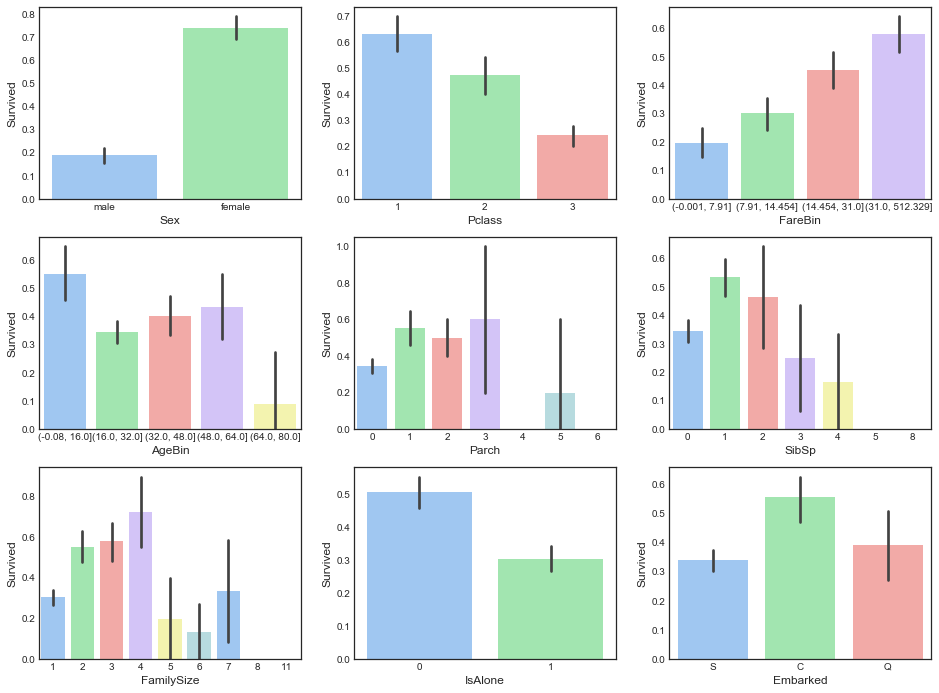

In [10]:
#使用seaborn作图来展示各特征与幸存率的关系
#设置子图的个数以及画布的大小
fig,saxis = plt.subplots(3,3,figsize=(16,12))

#定制配色方案
current_palette = sns.color_palette("pastel")

#定制画布的主题
current_style = sns.set_style('whitegrid')

sns.barplot(x = 'Sex',y = 'Survived',data = data1,palette=current_palette,ax = saxis[0,0])  #第0行第0列，即左上角第一个图形，后面的依此类推
sns.barplot(x = 'Pclass',y = 'Survived',data = data1,palette=current_palette,ax = saxis[0,1])
sns.barplot(x = 'FareBin',y = 'Survived',data = data1,palette=current_palette,ax = saxis[0,2])
sns.barplot(x = 'AgeBin',y = 'Survived',data = data1,palette=current_palette,ax = saxis[1,0])
sns.barplot(x = 'Parch',y = 'Survived',data = data1,palette=current_palette,ax = saxis[1,1])
sns.barplot(x = 'SibSp',y = 'Survived',data = data1,palette=current_palette,ax = saxis[1,2])
sns.barplot(x = 'FamilySize',y = 'Survived',data = data1,palette=current_palette,ax = saxis[2,0])
sns.barplot(x = 'IsAlone',y = 'Survived',data = data1,palette=current_palette,ax = saxis[2,1])
sns.barplot(x = 'Embarked',y = 'Survived',data = data1,palette=current_palette,ax = saxis[2,2])

#### 图形解释：
- 图1：女性的幸存率(0.742038)远高于男性(0.188908)
- 图2：一、二等舱位的乘客幸存率非常高(分别为0.629630，0.472826),三等舱乘客幸存率明显偏低(0.242363)
- 图3：支付票价越高的乘客幸存率越高，这和图2是相符的
- 图4：幸存率最高的年龄段在[0~16],其次是[48~64],可以推测是因为儿童和老年人被优先送上救生筏  
而[64~80]中的11人仅有1人获救，可以推测为该组乘客年龄偏高，在恶劣的海难中难以生存以待救援到来
- 图5-7：如果是家族结伴登船，则家族成员为4人时幸存概率较高，具体原因不详
- 图8：独身一人登船的乘客幸存率(0.505650)高于与家族结伴登船的乘客(0.303538)
- 图9：在法国法国 瑟堡-奥克特维尔(Cherbourg-Octeville)登船的人幸存率最高，原因亦不详

### 双因素与幸存率的相关性

Text(0.5,1,'Embarked vs Sex')

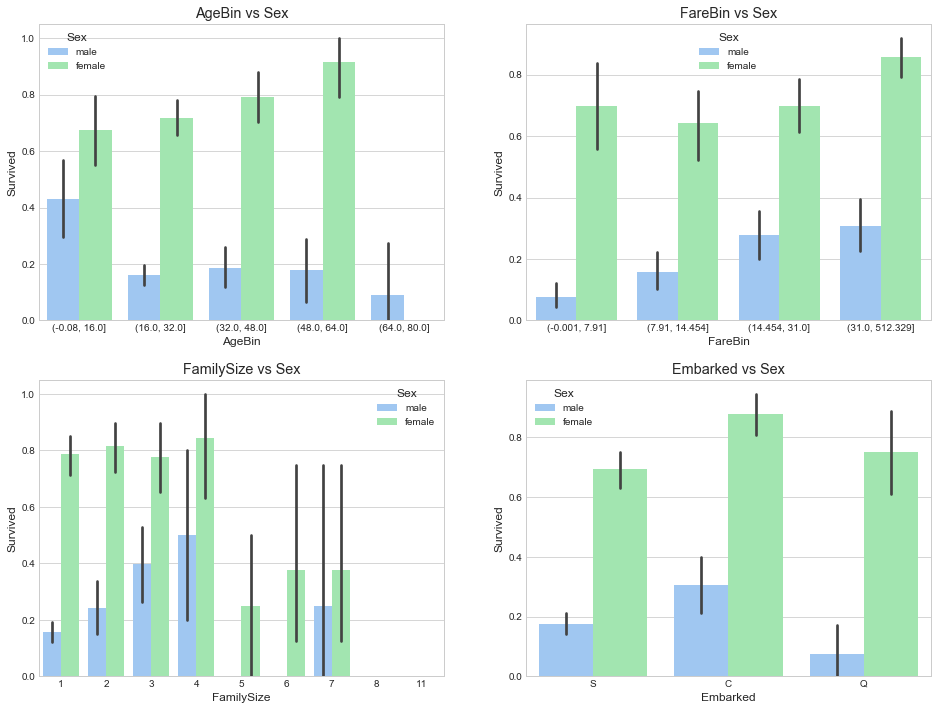

In [11]:
#设置子图的个数以及画布的大小
fig,saxis = plt.subplots(2,2,figsize=(16,12))

#定制清新的配色方案
current_palette = sns.color_palette("pastel")

#定制画布的主题
current_style = sns.set_style('whitegrid')

sns.barplot(x='AgeBin',y='Survived',hue='Sex',data=data1,palette=current_palette,ax=saxis[0,0]).set_title('AgeBin vs Sex')
sns.barplot(x='FareBin',y='Survived',hue='Sex',data=data1,palette=current_palette,ax=saxis[0,1]).set_title('FareBin vs Sex')
sns.barplot(x = 'FamilySize',y = 'Survived',hue = 'Sex',data = data1,palette=current_palette,ax=saxis[1,0]).set_title('FamilySize vs Sex')
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=data1,palette=current_palette,ax=saxis[1,1]).set_title('Embarked vs Sex')

#### 图形解释：
- 图1：各年龄段的女性乘客幸存率均很高，男性乘客的幸存率只有儿童组较高
- 图2：非常有趣的是各中票价段的女性乘客都有很高的幸存率，男性乘客只有在高票价段才有相对高的幸存率
- 图3：家族成员数不超过4人时，幸存率要显著高于成员数超过4人时的幸存率
- 图4：在法国瑟堡登船的乘客幸存率最高，且无论何处登船，女性乘客的幸存率显著高于男性

### 幸存乘客的年龄分布

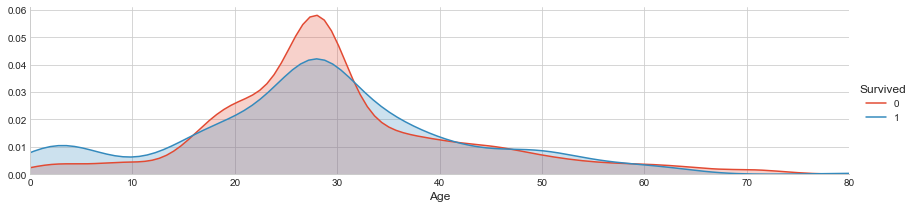

In [12]:
#针对乘客的存活情况，画出年龄分布
a = sns.FacetGrid(data1,hue = 'Survived',aspect = 4)
a.map(sns.kdeplot,'Age',shade = True)
a.set(xlim = (0,data1['Age'].max()))
a.add_legend()

### 三因素与幸存率的相关性

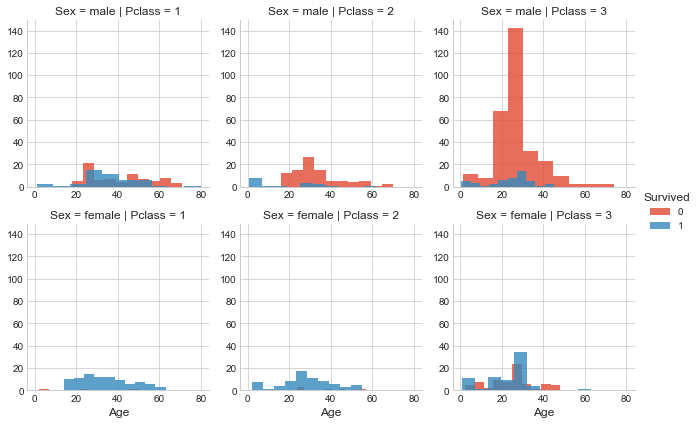

In [13]:
#用直方图比较性别，船舱等级，年龄与存活的关系
h = sns.FacetGrid(data1,row = 'Sex',col = 'Pclass',hue = 'Survived')
h.map(plt.hist,'Age',alpha = 0.8)
h.add_legend()

#### 图形解释：
- 第一列：一等舱的青壮年男性乘客生存率略高于死亡率，其余年龄段死亡率较高；一等舱的女性幸存率非常高，死亡率极低
- 第二列：二等舱的除儿童组外的男性乘客死亡率显著超过幸存率；二等舱的女性乘客幸存率非常高，死亡率极低
- 第三列：三等舱的各年龄段的男性乘客死亡率非常高，三等舱的小于40岁的女性乘客幸存率比较高

### 所有变量的相关系数热图

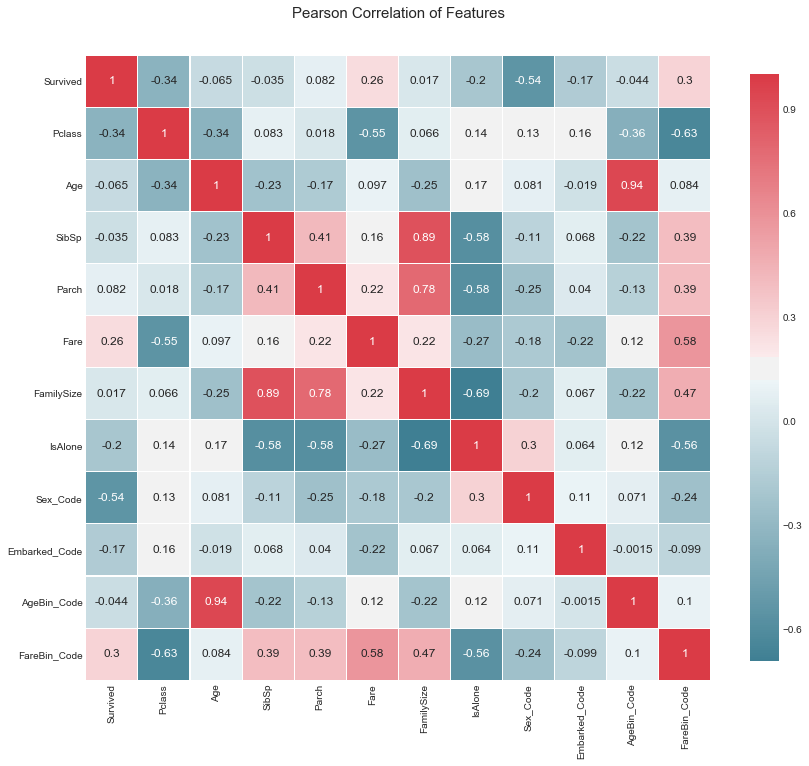

In [14]:
#相关性heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize = (14,12))
    colormap = sns.diverging_palette(220,10,as_cmap = True)
    
    _ = sns.heatmap(df.corr(),cmap=colormap,square=True,cbar_kws={'shrink':0.9},ax=ax,annot=True,linewidths=0.1,vmax=1.0,linecolor='white',annot_kws={'fontsize':12})
    plt.title("Pearson Correlation of Features", y = 1.05, size = 15)
    
correlation_heatmap(data1)

## 数据分析总结：
- 女性乘客的幸存率显著高于男性乘客，不论其舱位等级、年龄、票价、家族成员数、登船地点如何
- 富裕阶层的乘客幸存率显著高于贫穷阶层的乘客
- 儿童组和老年组的幸存率高于其他年龄段

显然，“优先照顾妇女、儿童、老人”的人道主义原则被很好的遵守了

## 5 模型拟合(决策树算法)

### 5.1 划分数据集

In [15]:
#划分训练集和测试集,random_state -->seed or control random number generator,默认训练集比例为75%
train1_x,test1_x,train1_y,test1_y = model_selection.train_test_split(data1[data1_x_calc],data1[Target],random_state=42)
train1_x_bin,test1_x_bin,train1_y_bin,test1_y_bin = model_selection.train_test_split(data1[data1_x_bin],data1[Target],random_state=42)

print("Data1 Shape:{}".format(data1.shape))
print("Train1 Shape:{}".format(train1_x_bin.shape))
print("Test1 Shape:{}".format(test1_x_bin.shape))

train1_x.head()

Data1 Shape:(891, 17)
Train1 Shape:(668, 6)
Test1 Shape:(223, 6)


,Sex_Code,Pclass,Embarked_Code,SibSp,Parch,Age,Fare
298,1,1,2,0,0,28.00,30.5000
884,1,3,2,0,0,25.00,7.0500
247,0,2,2,0,2,24.00,14.5000
478,1,3,2,0,0,22.00,7.5208
305,1,1,2,1,2,0.92,151.5500


In [16]:
train1_x_bin.head()

,Sex_Code,Pclass,Embarked_Code,FamilySize,AgeBin_Code,FareBin_Code
298,1,1,2,1,1,2
884,1,3,2,1,1,0
247,0,2,2,3,1,2
478,1,3,2,1,1,0
305,1,1,2,4,0,3


上面分别展示了train1_x和train1_x_bin两个版本,可见,train1_x_bin更精炼,因为它把SibSp和Parch压缩为FamilySize.下面的模型训练将使用train1_bin作为训练集.

### 5.2 训练模型

In [17]:
clf = tree.DecisionTreeClassifier()
clf.fit(train1_x_bin,train1_y_bin)  #默认使用'gini'信息增益

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
import graphviz 
dot_data = tree.export_graphviz(clf,out_file=None,feature_names=data1_x_bin,class_names = True,filled=True,rounded=True)
graph = graphviz.Source(dot_data)
graph.render('tree on Titanic_Analysis')  #保存决策树文档为PDF文件

'tree on Titanic_Analysis.pdf'

## 6. 评价模型性能

### 6.1 精准率

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf,train1_x_bin,train1_y_bin,cv=5)
print("在训练集上的精确率:{0:.2f}% +/-{1:.2f}%".format(scores.mean()*100,scores.std()*300))

在训练集上的精确率:79.35% +/-10.94%


In [20]:
scores = cross_val_score(clf,test1_x_bin,test1_y_bin,cv=5)
print("在训练集上的精确率:{0:.2f}% +/-{1:.2f}%".format(scores.mean()*100,scores.std()*300))

在训练集上的精确率:73.45% +/-19.66%


#### 在前面数据分析部分,我用统计学方法验证了数据集确实具有倾向性,在这种数据集上,精确率并不是一个最佳的评价标准,下面使用查准率(Precision)和查全率(Recall)作为评价标准.

### 6.2 查准率 查全率 混淆矩阵

In [21]:
from sklearn.model_selection import cross_val_predict
train1_y_predict = cross_val_predict(clf,train1_x_bin,train1_y_bin,cv=3)

In [22]:
train1_y_predict[:20]

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0], dtype=int64)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train1_y_predict,train1_y_bin)

array([[363,  95],
       [ 52, 158]], dtype=int64)

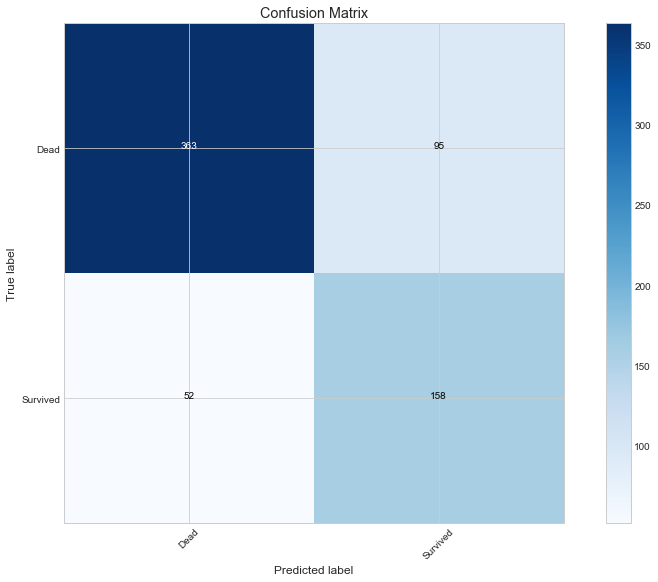

In [24]:
import itertools
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt = 'd';thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#compute confusion matrix
cnf_matrix = confusion_matrix(train1_y_predict,train1_y_bin)
np.set_printoptions(precision=2)
class_names = ['Dead','Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names)

In [25]:
from sklearn.metrics import precision_score,recall_score,f1_score
p_s = precision_score(train1_y_predict,train1_y_bin)
r_s = recall_score(train1_y_predict,train1_y_bin)
f1 = f1_score(train1_y_predict,train1_y_bin)
print('查准率为:{0:.2f}%,查全率为{1:.2f}%,F1_Score为:{2:.2f}%'.format(p_s*100,r_s*100,f1*100))

查准率为:62.45%,查全率为75.24%,F1_Score为:68.25%


由于这里训练出来的决策树模型没有经过调参,因此上面的查准率和查全率并不高.